# Our code

In [220]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [232]:
import nltk
import gensim
import re
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('stopwords')      # If this code block complains, comment out this line
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint

In [224]:
def readFile(filename):
    fileData = ""
    file = open("abstracts/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [225]:
corpus = []


for i in range (2012,2020):
    conference = readFile('usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2011,2020):
    conference = readFile('css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2000,2020):
    conference = readFile('ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2012,2020):
    conference = readFile('ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        
#print(corpus)
len(corpus)

3694

## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [226]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [227]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda z: remove_stopwords(z)          # Removes stopwords 
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [252]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [253]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

### Making the tfidf model
Not in use right now

In [254]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_M1)
#print(M1)

## Finding optimal number of topics

In [267]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        print(num_topics)
        
    return model_list, coherence_values

In [268]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, start=2, limit=102, step=4)

In [273]:
print(coherence_values)

[0.3250157403264292, 0.4116900808150424, 0.4277707176143622, 0.4419215919328382, 0.43300547700202796, 0.43331531510788773, 0.4507613241261437, 0.4401537362798364, 0.4436828004648704, 0.4321437701507225, 0.4287353256235635, 0.4345214971377863, 0.4207751964079457, 0.42903262376408574, 0.41356412264891634, 0.4094172711686478, 0.41385811506381215, 0.3971588021061537, 0.4020413137080951, 0.3944484660319797, 0.40475857425077855, 0.4043484985706639, 0.40233617235048474, 0.39983668071530726, 0.39050519443737175]


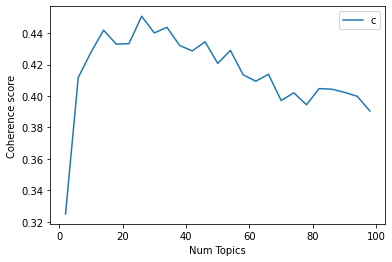

In [290]:
import matplotlib.pyplot as plt
# Show graph
limit=102; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [291]:
os.environ['MALLET_HOME']='mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=25,
                                             id2word=dictionary)

In [292]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(13,
  [('information', 0.08000640051204096),
   ('channel', 0.05552444195535643),
   ('demonstrate', 0.02808224657972638),
   ('secret', 0.025682054564365148),
   ('cache', 0.025362028962316985),
   ('data', 0.02472197775822066),
   ('sensitive', 0.02416193295463637),
   ('leak', 0.02392191375310025),
   ('share', 0.022801824145931675),
   ('paper', 0.018561484918793503)]),
 (23,
  [('browser', 0.05421303656597774),
   ('content', 0.030206677265500796),
   ('website', 0.029650238473767885),
   ('user', 0.0246422893481717),
   ('extension', 0.024085850556438793),
   ('site', 0.021303656597774244),
   ('popular', 0.02082670906200318),
   ('page', 0.013513513513513514),
   ('present', 0.012957074721780605),
   ('phishing', 0.012480127186009538)]),
 (19,
  [('program', 0.054561015619428),
   ('input', 0.043220882961272376),
   ('technique', 0.0328079309607018),
   ('test', 0.03259396619356679),
   ('code', 0.031024891234576708),
   ('binary', 0.02617502317951644),
   ('approach', 0.02232

## Setting upp the lda model
Used insted of LDA mallet

In [213]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(tfidf_M1, 
                num_topics=2, 
                id2word = dictionary, 
                passes=18, 
                random_state =0)

KeyboardInterrupt: 

In [ ]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=corpus_clean_bigram, dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
topics = ldamallet.print_topics(num_topics=100, num_words=6)

for topic in topics:
    print(topic)

## Visualisation of topics
First creating a lda mallet model and then visualising

In [293]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [294]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.018624 -0.078286       1        1  4.195850
6     -0.107293 -0.089451       2        1  4.122230
19     0.239272  0.002171       3        1  4.109319
24     0.050436 -0.073386       4        1  4.107820
7      0.190414  0.078938       5        1  4.090390
1      0.178984 -0.027415       6        1  4.080198
12     0.118089  0.101490       7        1  4.059439
16    -0.105872 -0.001019       8        1  4.052535
0     -0.111331 -0.246177       9        1  4.020452
2      0.105585 -0.119019      10        1  4.017378
17    -0.196760 -0.028938      11        1  4.011739
23    -0.045481  0.094942      12        1  3.983773
4      0.040366 -0.067413      13        1  3.975503
20    -0.024279 -0.124154      14        1  3.971488
18    -0.084847  0.214748      15        1  3.968819
5     -0.137971  0.204876      16        1  3.966691
8     -0.109188  0.148841      17        1  3.962271
10    -0.064695 -0.060538      18        1  3.942548
9     -0.098355  0.183513      19        1  3.942521
11    -0.075191  0.053810      20        1  3.919102
3      0.122183  0.093820      21        1  3.910171
22    -0.129579 -0.195297      22        1  3.906060
21     0.022078  0.001458      23        1  3.899570
14     0.033002 -0.086685      24        1  3.892556
15     0.171810  0.019172      25        1  3.891580, topic_info=            Term         Freq        Total Category  logprob  loglift
200       attack  4117.000000  4117.000000  Default  30.0000  30.0000
297     security  4250.000000  4250.000000  Default  29.0000  29.0000
196         user  3393.000000  3393.000000  Default  28.0000  28.0000
14          data  2913.000000  2913.000000  Default  27.0000  27.0000
379      network  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
514         high   133.353670   795.917444  Topic25  -4.6445   1.4599
203        based   152.106530  1566.426142  Topic25  -4.5129   0.9144
83   demonstrate   137.520972  1156.836161  Topic25  -4.6137   1.1167
71       address   131.270019   801.936004  Topic25  -4.6602   1.4366
511        exist   133.353670   998.178121  Topic25  -4.6445   1.2334

[2033 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2880      5  0.989889        abnormal
2365      6  0.994102        abstract
545       6  0.872241     abstraction
545      13  0.129658     abstraction
0        12  0.349424           abuse
...     ...       ...             ...
69       21  0.004994            year
3750     25  0.959854            yelp
3047     25  1.033688         youtube
2657     22  0.997362  zero_knowledge
3338     14  0.986339            zeus

[3177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 20, 25, 8, 2, 13, 17, 1, 3, 18, 24, 5, 21, 19, 6, 9, 11, 10, 12, 4, 23, 22, 15, 16])

### Topics per document

In [264]:
lda_mallet_model.get_document_topics(M1[1],minimum_probability=0)

[(0, 0.011396887),
 (1, 0.0076833675),
 (2, 0.007103493),
 (3, 0.007518951),
 (4, 0.0070084287),
 (5, 0.007370742),
 (6, 0.009986331),
 (7, 0.009191074),
 (8, 0.011486954),
 (9, 0.007335104),
 (10, 0.008869761),
 (11, 0.0068968716),
 (12, 0.008379075),
 (13, 0.008957518),
 (14, 0.0071698856),
 (15, 0.0069242963),
 (16, 0.012291154),
 (17, 0.0076924437),
 (18, 0.008615531),
 (19, 0.009352769),
 (20, 0.008258652),
 (21, 0.0061636735),
 (22, 0.009199122),
 (23, 0.00759302),
 (24, 0.008173473),
 (25, 0.009225343),
 (26, 0.008373964),
 (27, 0.006815856),
 (28, 0.0085789),
 (29, 0.011638744),
 (30, 0.0073855626),
 (31, 0.0074180085),
 (32, 0.008228985),
 (33, 0.010131112),
 (34, 0.010159706),
 (35, 0.008517007),
 (36, 0.008936451),
 (37, 0.01563098),
 (38, 0.008695317),
 (39, 0.007884963),
 (40, 0.01631479),
 (41, 0.007135726),
 (42, 0.008530905),
 (43, 0.008413561),
 (44, 0.01004996),
 (45, 0.016562955),
 (46, 0.008415385),
 (47, 0.009797232),
 (48, 0.0070333173),
 (49, 0.0099623455),
 (50,